In [1]:
import os
import sys
import yaml

import numpy as np
import matplotlib.pyplot as plt

project_root = os.path.abspath(os.path.join(os.getcwd(), "../../.."))
sys.path.insert(0, project_root)


In [2]:
target_dir = "./robust/target/signals"
shadow_dir = "./robust/output/signals"

no_shadows = 20 #64
no_samples = 20 #0

random_target = False


In [3]:
from sampling import load_results, bootstrap_sampling # hold_one_out_sampling

if random_target:
    target_logits, target_inmask = None, None # sampler will intepret this as to randomize over 
    shadow_logits, shadow_inmask = load_results([target_dir, shadow_dir])
    print(shadow_logits.shape, shadow_inmask.shape)
else:
    target_logits, target_inmask = load_results(target_dir)
    shadow_logits, shadow_inmask = load_results(shadow_dir)
    print(target_logits.shape, target_inmask.shape)
    print(shadow_logits.shape, shadow_inmask.shape)


NOTE: all masks are unique as expected: 1 total
NOTE: all masks are unique as expected: 20 total
(60000, 1) (60000, 1)
(60000, 20) (60000, 20)


### Bootstrap sampling

Use bootstrap method to get many samples of ROC curve estimates. 

In [4]:
from leakpro.attacks.mia_attacks.lira import lira_vectorized

def lira_score_vectorized(target_logits, shadow_logits, shadow_inmask):
    return lira_vectorized(target_logits, shadow_logits, shadow_inmask, var_calculation = "individual_carlini")

samples = bootstrap_sampling(no_shadows, no_samples, shadow_logits, shadow_inmask, target_logits, target_inmask, vec_mia_fun=lira_score_vectorized)


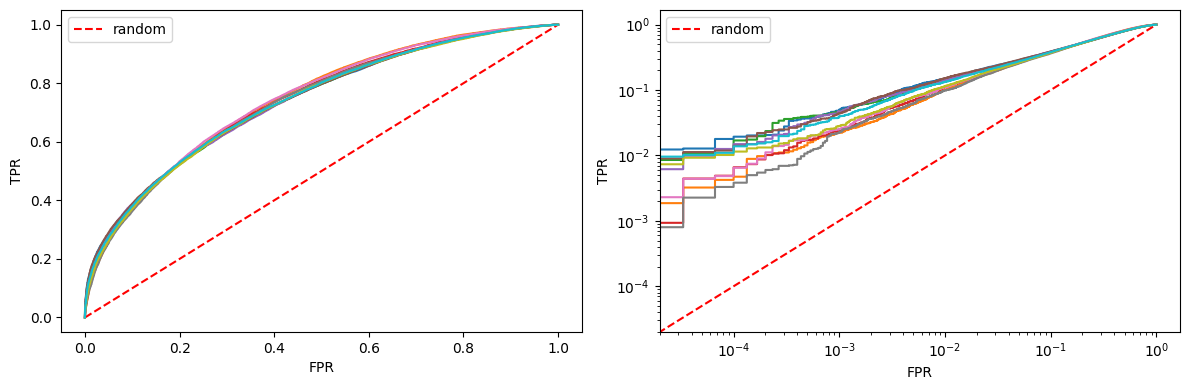

In [5]:
unique_fpr = sorted(np.unique(np.concat([fpr for (fpr, tpr) in samples])))

fig, axs = plt.subplots(1,2,figsize=(12,4))
axs[0].plot(unique_fpr, unique_fpr, 'r--', label="random")
axs[1].loglog(unique_fpr, unique_fpr, 'r--', label="random")
for i in [0,1]:
    for (fpr, tpr) in samples[:10]:
        axs[i].plot(fpr, tpr)
    axs[i].set_xlabel("FPR")
    axs[i].set_ylabel("TPR")
    axs[i].legend()
plt.tight_layout()
plt.show()


### Plot the average curve with confidence bands

The confidence bands are wider for small FPR. This is more visible in the log-log plot to the right. 

The default confidence is set at 95%. For higher confidence you may have to take more samples. 


In [6]:
from sampling import interpolate_unique

interp_tpr = np.array([interpolate_unique(unique_fpr, fpr, tpr) for (fpr, tpr) in samples])
len(unique_fpr), interp_tpr.shape


(28776, (10, 28776))

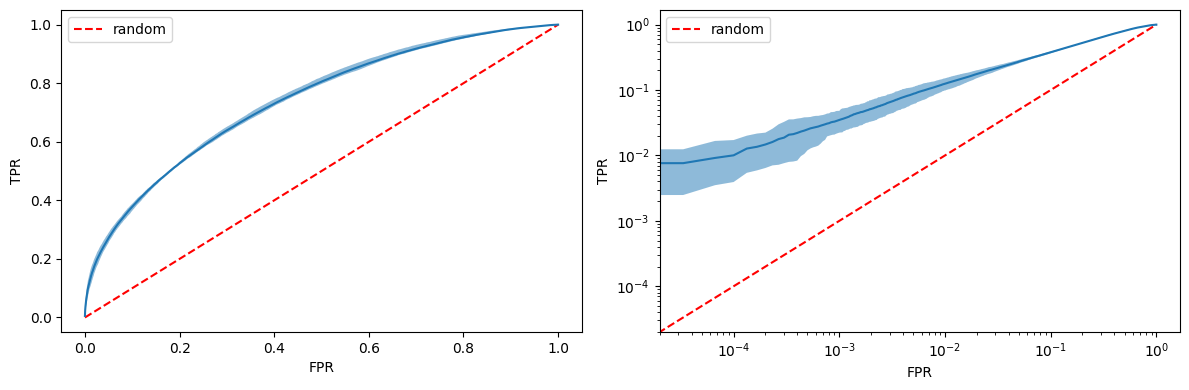

In [7]:
fig, axs = plt.subplots(1,2,figsize=(12,4))
axs[0].plot(fpr, fpr, 'r--', label="random")
axs[1].loglog(fpr, fpr, 'r--', label="random")
for i in [0,1]:
    axs[i].plot(unique_fpr,np.mean(interp_tpr,axis=0))
    axs[i].fill_between(unique_fpr,np.percentile(interp_tpr,2.5,axis=0),np.percentile(interp_tpr,97.5,axis=0), alpha=0.5)
    axs[i].set_xlabel("FPR")
    axs[i].set_ylabel("TPR")
    axs[i].legend()
plt.tight_layout()
plt.show()


### Plot histograms

Histograms of TPR for different FPR. 

Increase the no_samples to above 100 to get smoother historgrams.


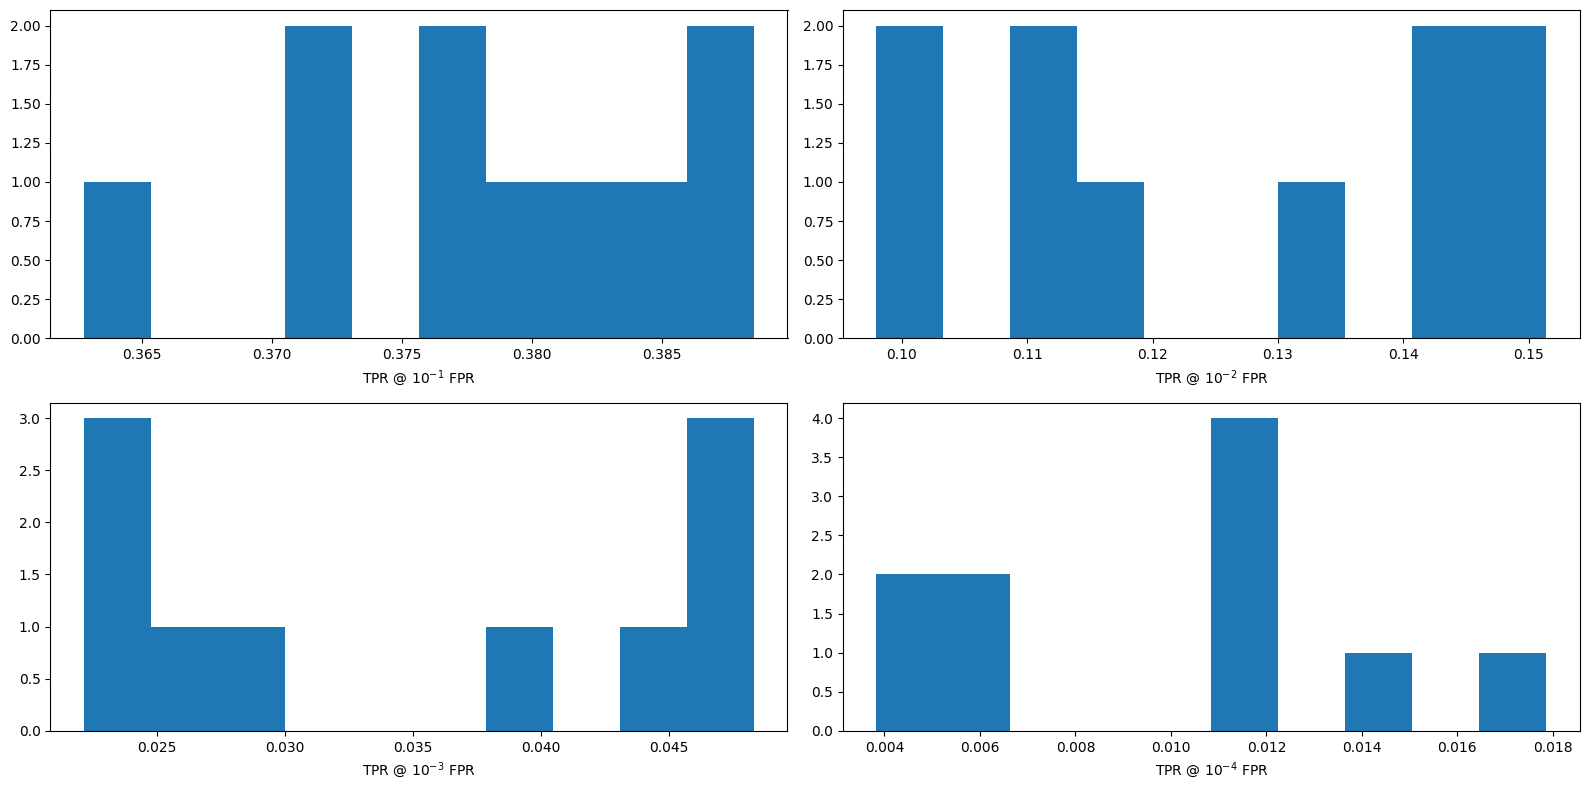

In [8]:
fig, axs = plt.subplots(2,2, figsize=(16,8))
axs[0,0].hist([interpolate_unique(0.1,fpr,tpr) for (fpr,tpr) in samples], bins=10)
axs[0,1].hist([interpolate_unique(0.01,fpr,tpr) for (fpr,tpr) in samples], bins=10)
axs[1,0].hist([interpolate_unique(0.001,fpr,tpr) for (fpr,tpr) in samples], bins=10)
axs[1,1].hist([interpolate_unique(0.0001,fpr,tpr) for (fpr,tpr) in samples], bins=10)
axs[0,0].set_xlabel("TPR @ $10^{-1}$ FPR")
axs[0,1].set_xlabel("TPR @ $10^{-2}$ FPR")
axs[1,0].set_xlabel("TPR @ $10^{-3}$ FPR")
axs[1,1].set_xlabel("TPR @ $10^{-4}$ FPR")
plt.tight_layout()
plt.show()


### Dependence on the number of shadow models

In this experiment we analyse how the estimted privacy risk metric varies with the number of available shadow models. 


In [9]:
experiment = {
    no_shadows: samples
}

for K in [4, 8, 16, 32, 48]:
    M = no_samples
    print(f"take {M} samples at {K} number of shadow models")
    experiment[K] = bootstrap_sampling(K, M, shadow_logits, shadow_inmask, target_logits, target_inmask)
    

take 10 samples at 4 number of shadow models


/mnt/bigger/rbdev/LeakPro_robustness/leakpro/attacks/mia_attacks/lira.py:284: RuntimeWarning: Mean of empty slice
  out_means = np.nanmean(np.where(~shadow_inmask, shadow_logits, np.nan), axis=1)
/mnt/bigger/rbdev/LeakPro_robustness/leakpro/attacks/mia_attacks/lira.py:285: RuntimeWarning: Mean of empty slice
  in_means = np.nanmean(np.where(shadow_inmask, shadow_logits, np.nan), axis=1)
/mnt/bigger/rbdev/LeakPro_robustness/leakpro/attacks/mia_attacks/lira.py:284: RuntimeWarning: Mean of empty slice
  out_means = np.nanmean(np.where(~shadow_inmask, shadow_logits, np.nan), axis=1)
/mnt/bigger/rbdev/LeakPro_robustness/leakpro/attacks/mia_attacks/lira.py:285: RuntimeWarning: Mean of empty slice
  in_means = np.nanmean(np.where(shadow_inmask, shadow_logits, np.nan), axis=1)
/mnt/bigger/rbdev/LeakPro_robustness/leakpro/attacks/mia_attacks/lira.py:284: RuntimeWarning: Mean of empty slice
  out_means = np.nanmean(np.where(~shadow_inmask, shadow_logits, np.nan), axis=1)
/mnt/bigger/rbdev/LeakPr

take 10 samples at 8 number of shadow models


/mnt/bigger/rbdev/LeakPro_robustness/leakpro/attacks/mia_attacks/lira.py:284: RuntimeWarning: Mean of empty slice
  out_means = np.nanmean(np.where(~shadow_inmask, shadow_logits, np.nan), axis=1)
/mnt/bigger/rbdev/LeakPro_robustness/leakpro/attacks/mia_attacks/lira.py:285: RuntimeWarning: Mean of empty slice
  in_means = np.nanmean(np.where(shadow_inmask, shadow_logits, np.nan), axis=1)
/mnt/bigger/rbdev/LeakPro_robustness/leakpro/attacks/mia_attacks/lira.py:284: RuntimeWarning: Mean of empty slice
  out_means = np.nanmean(np.where(~shadow_inmask, shadow_logits, np.nan), axis=1)
/mnt/bigger/rbdev/LeakPro_robustness/leakpro/attacks/mia_attacks/lira.py:285: RuntimeWarning: Mean of empty slice
  in_means = np.nanmean(np.where(shadow_inmask, shadow_logits, np.nan), axis=1)


take 10 samples at 16 number of shadow models
take 10 samples at 32 number of shadow models
take 10 samples at 48 number of shadow models


In [10]:
def stats(result, tail=0.01):
    temp = np.array([
        [interpolate_unique(tail,fpr,tpr) for (fpr, tpr) in result] 
            for tail in [0.1,0.01,0.001,0.0001]
    ])
    return temp.mean(axis=1), np.percentile(temp, 2.5, axis=1), np.percentile(temp, 97.5, axis=1)
    
np.array(stats(experiment[no_shadows])).shape    


(3, 4)

In [11]:
all_no_shadows_models = np.sort(list(experiment.keys()))

test = [stats(experiment[K]) for K in all_no_shadows_models]
test = np.array(test)
test.shape


(6, 3, 4)

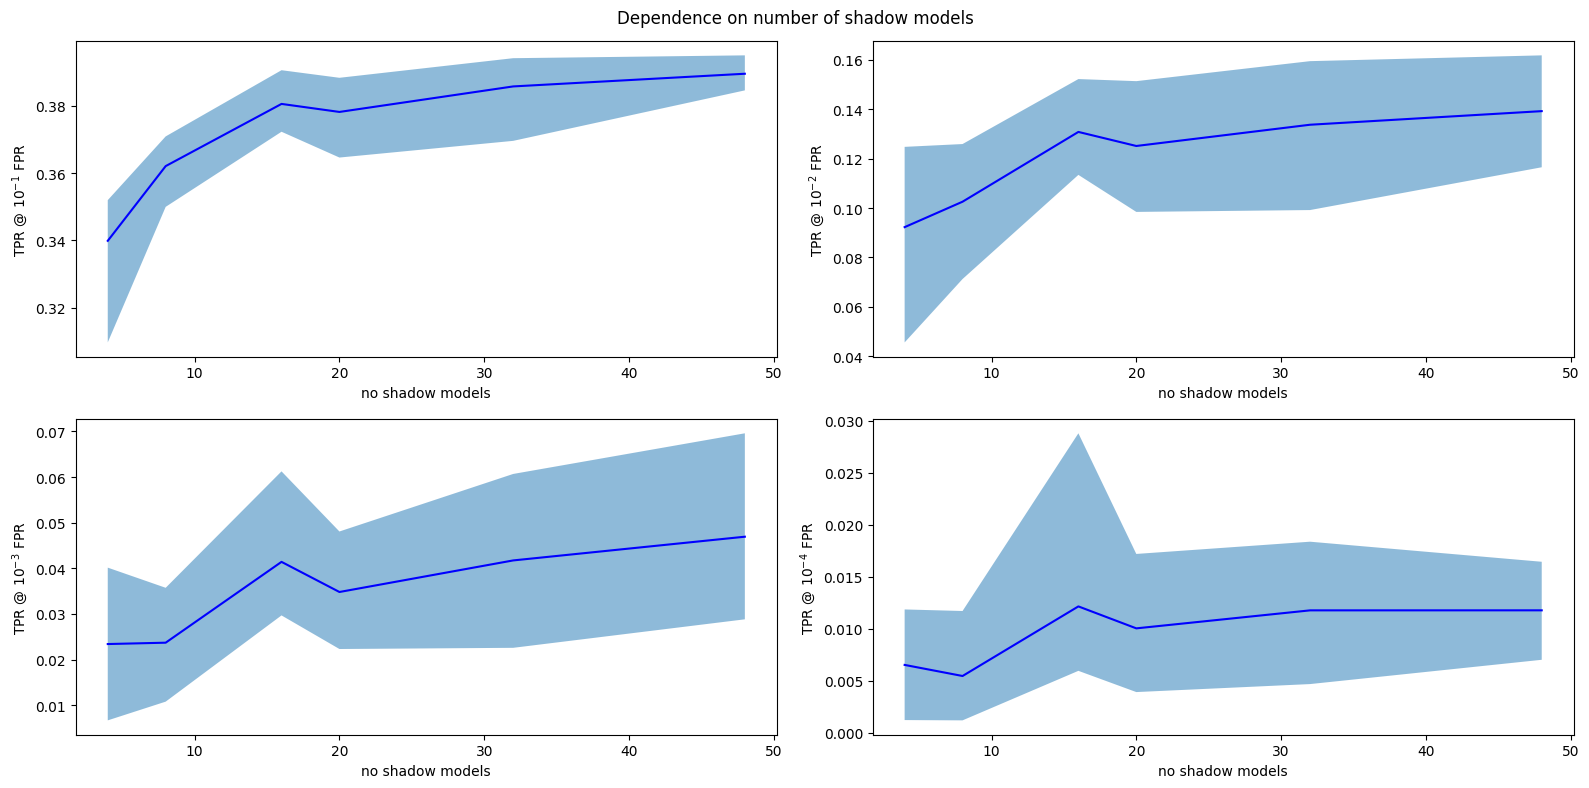

In [12]:
fig, axs = plt.subplots(2,2, figsize=(16,8))
for i in range(4):
    ax = axs[i//2,i%2]
    ax.plot(all_no_shadows_models, test[:,0,i],'b-')
    #ax.plot(all_no_shadows_models, test[:,1,i],'b--')
    #ax.plot(all_no_shadows_models, test[:,2,i],'b--')
    ax.fill_between(all_no_shadows_models, test[:,1,i], test[:,2,i], alpha=0.5)
    ax.set_ylabel("TPR @ $10^{"+f"{-1-i}"+"}$ FPR")
    ax.set_xlabel("no shadow models")
plt.suptitle("Dependence on number of shadow models")
plt.tight_layout()
plt.show()
